In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
words = open("names.txt", "r").read().splitlines()
words[:8]
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(["."]+chars)}
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)
block_size = 8 # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])   # training
Xdev, Ydev = build_dataset(words[n1:n2]) # dev
Xte,  Yte  = build_dataset(words[n2:])   # test

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27
torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [34]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained w/ running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to Zscore
        self.out = self.gamma * xhat + self.beta # Zscore output linearity
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    (1 - self.momentum) * self.running_mean + 
                    self.momentum * xmean
                )
                self.running_var = (
                    (1 - self.momentum) * self.running_var +
                    self.momentum * xvar
                )

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, (C * self.n)) # n = number of consec vectors to flatten

        if x.shape[1] == 1:
            # remove unnecessary dimension
            x = x.squeeze(1)
            
        self.out = x
        return self.out
        
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [64]:
torch.manual_seed(42)

In [72]:
n_embd = 24 # dim of embedding
n_hidden = 128 # n neurons

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # 2
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # 4
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # 8
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make the last layer less confident so it's not confidently wrong

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [73]:
# same optimization
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # build minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update SGD
    lr = 0.1 if i < 150_000 else 0.01 # decay
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2926
  10000/ 200000: 2.2388
  20000/ 200000: 1.6701
  30000/ 200000: 2.2818
  40000/ 200000: 2.5519
  50000/ 200000: 1.7478
  60000/ 200000: 1.7393
  70000/ 200000: 2.1148
  80000/ 200000: 1.8818
  90000/ 200000: 2.1232
 100000/ 200000: 1.9049
 110000/ 200000: 2.2078
 120000/ 200000: 2.1796
 130000/ 200000: 1.7295
 140000/ 200000: 1.9546
 150000/ 200000: 2.1470
 160000/ 200000: 1.7059
 170000/ 200000: 1.7964
 180000/ 200000: 1.7097
 190000/ 200000: 1.5593


In [74]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


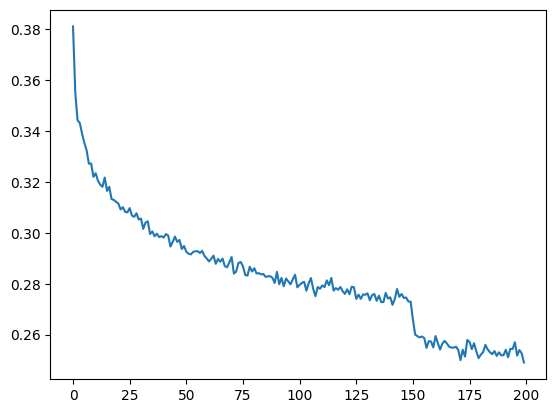

In [75]:
# running avg the losses
window = 1_000
losst = torch.tensor(lossi)
plt.plot(losst.view(-1, window).mean(dim=1))

In [76]:
# eval mode
for layer in model.layers:
    layer.training = False

In [77]:
# eval loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7664377689361572
val 1.9920543432235718


In [81]:
# sample from the model
print('sampling from model:')
for _ in range(20):
    out = []
    context = [0] * block_size # null init
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample: this is where nondeterminism comes from!
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift ctx window
        context = context[1:] + [ix]
        out.append(ix)
        # if sampled null, break
        if ix == 0:
            break

    print('\t',''.join(itos[i] for i in out))
    

sampling from model:
	 kataleya.
	 aditley.
	 aiyla.
	 troy.
	 lavaon.
	 gyahlim.
	 ellis.
	 naiya.
	 rosemile.
	 lynnett.
	 ivyannal.
	 jady.
	 laiza.
	 brysen.
	 ryebeka.
	 yemariain.
	 jaxstyn.
	 canta.
	 shya.
	 elilyn.
